# Classify heart disease using patients' age, maximum heart rate (MHR) during strenuous exercise, and ST depression induced by exercise.

## Introduction

Heart disease *(cardiovascular disease)* encompasses various conditions affecting the heart and blood vessels, often leading to heart attacks due to arterial blockages. Heart attacks may be fatal if not immediately treated; thus, early identification and treatment are crucial to prevent severe complications. 

The *Heart Attack dataset* used provides 13 variables that are possibly linked to heart disease, with whether or not they developed the disease. This study aims **uses the K-nearest neighbors (KNN) algorithm to predict heart disease likelihood**, focusing on *age, maximum heart rate, and exercise-induced ST depression*. Scientifically, age is a key factor, especially in those aged 65 and older. Additionally, low maximum heart rate and ST depression are early heart disease symptoms. Reduced maximum heart rate indicates lower cardiovascular fitness, while ST depression on an electrocardiogram signals potential issues like myocardial ischemia.

The question being addressed is: **Can heart disease be accurately predicted based on a patient’s age, maximum heart rate during strenuous exercise, and ST depression induced by exercise?**

## Preliminary exploratory data analysis

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
set.seed(1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Reading the dataframe from file
heart_data <- read_csv("Heart Attack Data Set.csv")

# Cleaning, warngling data
heart_clean_data <- heart_data |>
        mutate(target = as_factor(target))|>     
        mutate(target = fct_recode(target, "TRUE" = "1", "FALSE" = "0")) |> #Change target to factor TRUE/FALSE
        mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
               fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
               exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
               ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope)))  
head(heart_clean_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,3,145,233,1,0,150,0,2.3,0,0,1,TRUE
37,1,2,130,250,0,1,187,0,3.5,0,0,2,TRUE
41,0,1,130,204,0,0,172,0,1.4,2,0,2,TRUE
56,1,1,120,236,0,1,178,0,0.8,2,0,2,TRUE
57,0,0,120,354,0,1,163,1,0.6,2,0,2,TRUE
57,1,0,140,192,0,1,148,0,0.4,1,0,1,TRUE


In [4]:
# Splitting dataframe into training, testing datasets
heart_split <- initial_split(heart_clean_data, prop = 0.75, strata = target)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)


In [5]:
#Exploratory data analysis
heart_ana <- heart_training |>
             group_by(target) |>
             summarize(n_of_obs = n(),
                       mean_age = mean(age),
                       mean_thalach = mean(thalach),
                       mean_oldpeak= mean(oldpeak),
                       missing_rows= sum(is.na(~.)))

heart_ana

Warning message:
“There were 2 warnings in `summarize()`.
The first warning was:
ℹ In argument: `missing_rows = sum(is.na(~.))`.
ℹ In group 1: `target = FALSE`.
Caused by warning in `is.na()`:
! is.na() applied to non-(list or vector) of type 'language'
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


target,n_of_obs,mean_age,mean_thalach,mean_oldpeak,missing_rows
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>
FALSE,103,56.70874,138.6117,1.5854369,0
TRUE,123,52.48780,159.0569,0.5796748,0


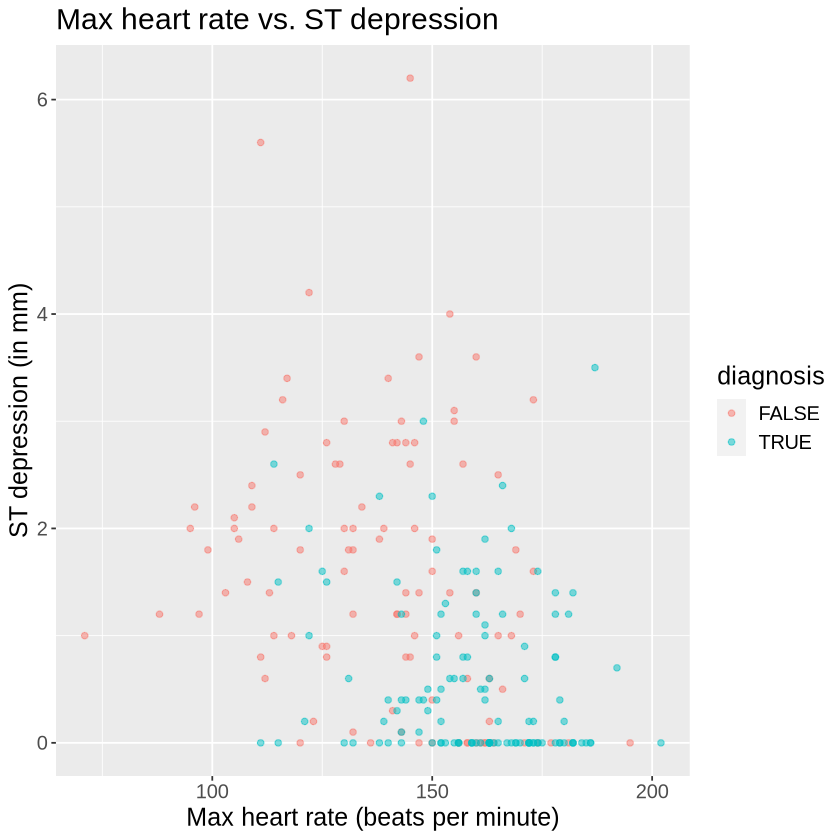

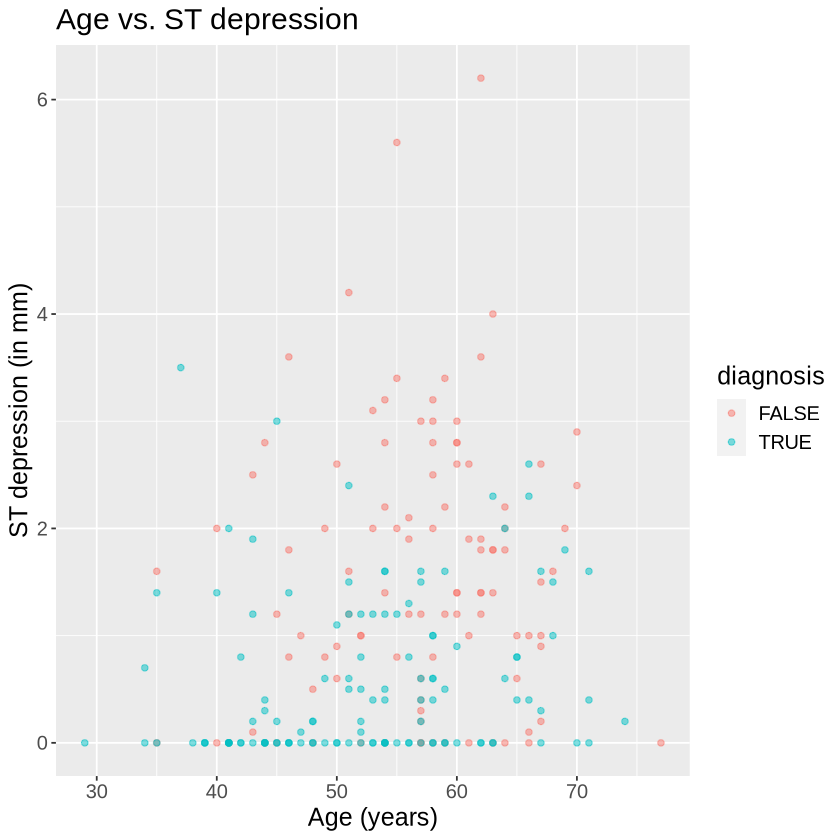

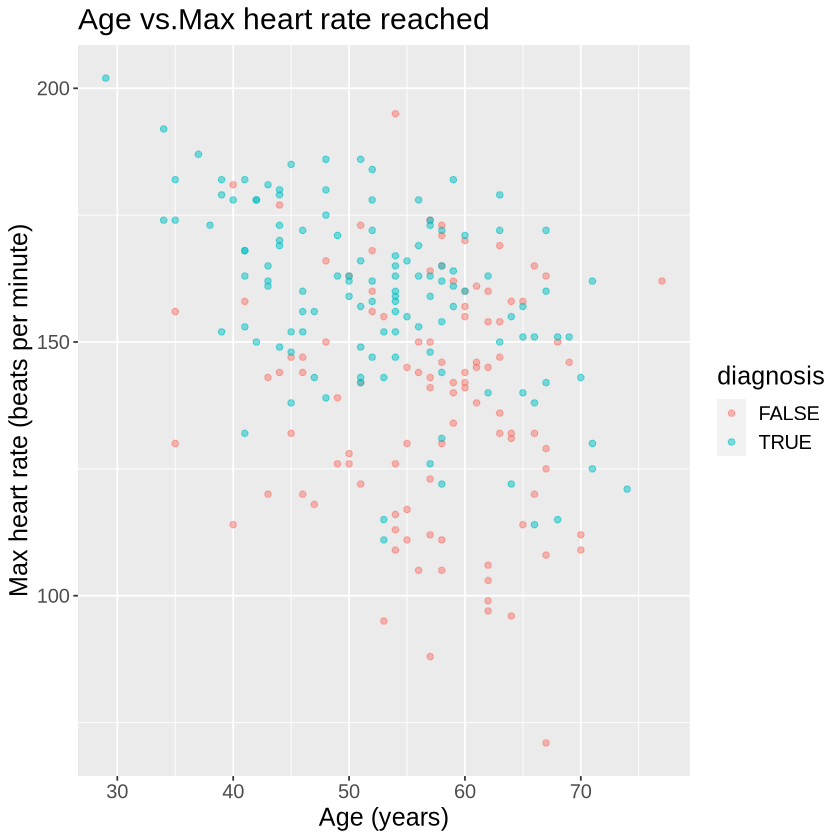

In [16]:
#plotting the training data
plot1 <- ggplot(heart_training, aes(x = thalach, y = oldpeak, color = target)) +
            geom_point(alpha = 0.5) +
            labs(x = "Max heart rate (beats per minute)", y = "ST depression (in mm)", color = "diagnosis", title = "Max heart rate vs. ST depression") +
            theme(text = element_text(size = 15))

plot2 <- ggplot(heart_training, aes(x = age, y = oldpeak, color = target)) +
             geom_point(alpha = 0.5) +
             labs(x = "Age (years)", y = "ST depression (in mm)", color = "diagnosis", , title = "Age vs. ST depression") +
             theme(text = element_text(size = 15)) 

plot3 <- ggplot(heart_training, aes(x = age, y = thalach, color = target)) +
             geom_point(alpha = 0.5) +
             labs(x = "Age (years)", y = "Max heart rate (beats per minute)", color = "diagnosis", title = "Age vs.Max heart rate reached") +
             theme(text = element_text(size = 15)) 

# Plot the three graphs
plot1
plot2
plot3